In [1]:
import numpy as np
import torch
from scipy.special import softmax
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import pandas as pd

/home/xinmeng/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
class DualOptimizer():
    def __init__(self,
                 helpfulness_scores,
                 safety_scores,
                 thresholds, # E_{pi}[safety] >= thresholds
                 kl_coeff,
                 **kwargs):
        self.helpfulness_scores = helpfulness_scores
        self.safety_scores = safety_scores
        self.thresholds = thresholds
        self.kl_coeff = kl_coeff
        self.kwargs = kwargs
    
    def log_mean_Z_values(self, logits):
        return np.log(np.mean(np.exp(logits-logits.max(axis=1).reshape(-1, 1)), axis=1))+logits.max(axis=1)
    
    def solve(self, optimizer='GD', set_optimum=False, verbose=False, **kwargs):
        lam_init = 1 if 'lam_init' not in kwargs.keys() else kwargs['lam_init']
        lr = 1 if 'lr' not in kwargs.keys() else 2*kwargs['lr']
        max_iters = 200 if 'num_iters' not in kwargs.keys() else kwargs['num_iters']
        err = 1e-5 if 'err' not in kwargs.keys() else kwargs['err']
        if optimizer == 'scipy':
            def dual_loss(lam):
                logits = (self.helpfulness_scores + (self.safety_scores - self.thresholds) * lam) /self. kl_coeff
                logits_max = logits.max(axis=1).reshape(-1, 1)
                return self.kl_coeff*np.mean(np.log(np.mean(np.exp(logits-logits_max)))+logits_max)

            result = minimize_scalar(dual_loss, bounds = (-1, 10))
            if set_optimum:
                self.lam_star = result.x

        if optimizer == 'GD':
            is_converge = False
            num_loops = 0
            while not is_converge:
                lam = lam_init
                lr = lr/2**num_loops # learning rate decay
                lam_trajectory = []
                objective_trajectory = []
                constraint_trajectory = []
                helpfulness_trajectory = []
                safety_trajectory = []
                for idx_iter in range(max_iters):
                    logits = (self.helpfulness_scores + (self.safety_scores - self.thresholds) * lam) / self.kl_coeff
                    sm_probs = softmax(logits, axis=1)
                    gradient = np.sum(sm_probs * (self.safety_scores - self.thresholds), axis=1).mean()
                    lam = np.maximum(lam - lr*gradient, 0)
                    lam_trajectory.append(lam)
                    objective_trajectory.append(self.kl_coeff*np.mean(self.log_mean_Z_values(logits))-lam*gradient)
                    constraint_trajectory.append(gradient)
                    helpfulness_trajectory.append(np.sum(sm_probs * self.helpfulness_scores, axis=1).mean())
                    safety_trajectory.append(np.sum(sm_probs * self.safety_scores, axis=1).mean())
                    if idx_iter >= 10 and np.abs(lam-np.array(lam_trajectory[-1:-6:-1])).max()<err: # the maximal difference, compared to the last 5 iterations, are smaller than 1e-5
                        is_converge = True
                        if verbose:
                            print(f'The optimization converges to a finite maximizer!')
                        break
                if is_converge:
                    if set_optimum:
                        self.lam_star = lam
                    break
                num_loops += 1
                if num_loops >= 10: # fail the optimization after 5 loops
                    print(f'The dual problem (threshold={self.thresholds}, sample_shape={self.helpfulness_scores.shape}) may not have a finite maximizer!')
                    if set_optimum:
                        self.lam_star = None
                    break
            return lam_trajectory, objective_trajectory, constraint_trajectory, helpfulness_trajectory, safety_trajectory if is_converge else [None] * 5

In [3]:
full_scores_v1 = torch.load('/home/xinmeng/safe-rlhf/output/score/alpaca-7b-reproduced_cost_reward_scores_v1.pt')[:,:,-2:].cpu().numpy()
full_helpfulness_scores_v1 = full_scores_v1[:,:,0]
full_safety_scores_v1 = -full_scores_v1[:,:,1]
print(f'The expected (helpfulness, safety) score of the reference model is {full_helpfulness_scores_v1.mean(), full_safety_scores_v1.mean()}')

full_scores_new2_v1 = torch.load('/home/xinmeng/safe-rlhf/output/score/alpaca-7b-reproduced_cost_reward_scores_new2_v1.pt')[:,:,-2:].cpu().numpy()
full_helpfulness_scores_new2_v1 = full_scores_new2_v1[:,:,0]
full_safety_scores_new2_v1 = -full_scores_new2_v1[:,:,1]
print(f'The expected (helpfulness, safety) score of the reference model is {full_helpfulness_scores_new2_v1.mean(), full_safety_scores_new2_v1.mean()}')

length = min(full_scores_v1.shape[0], full_scores_new2_v1.shape[0])

full_helpfulness_scores = np.concatenate([full_helpfulness_scores_v1[:length], full_helpfulness_scores_new2_v1[:length]], axis=1)
full_safety_scores = np.concatenate([full_safety_scores_v1[:length], full_safety_scores_new2_v1[:length]], axis=1)
print(f'The expected (helpfulness, safety) score of the reference model is {full_helpfulness_scores.mean(), full_safety_scores.mean()}')

The expected (helpfulness, safety) score of the reference model is (-11.74012, -1.6504555)
The expected (helpfulness, safety) score of the reference model is (-11.681619, -1.6175346)
The expected (helpfulness, safety) score of the reference model is (-11.704958, -1.6067969)


In [4]:
threshold_grid = np.linspace(-0.08463882, 2, 5)
num_prompt = 1000
num_response = 128

np.random.seed(42)
idx_sample = np.random.choice(length, 1000, replace=False)

Text(0, 0.5, 'Helpfulness')

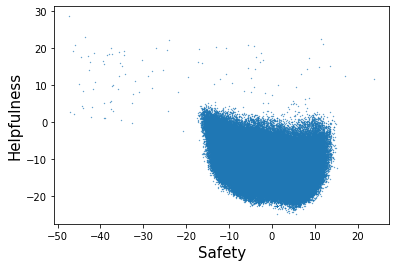

In [5]:
plt.scatter(full_safety_scores, full_helpfulness_scores, s=0.1)
plt.xlabel('Safety', fontsize=15)
plt.ylabel('Helpfulness', fontsize=15)

In [6]:
print(f'The expected (helpfulness, safety) score of the reference model is {full_helpfulness_scores.mean(), full_safety_scores.mean()}')
print(f'The expected (helpfulness, safety) score of the helpfulness-only model is {np.sum(softmax((full_helpfulness_scores)/0.1, axis=1) * full_helpfulness_scores, axis=1).mean(), np.sum(softmax((full_helpfulness_scores)/0.1, axis=1) * full_safety_scores, axis=1).mean()}')
print(f'The expected (helpfulness, safety) score of the safety-only model is {np.sum(softmax((full_safety_scores)/0.1, axis=1) * full_helpfulness_scores, axis=1).mean(), np.sum(softmax((full_safety_scores)/0.1, axis=1) * full_safety_scores, axis=1).mean()}')

The expected (helpfulness, safety) score of the reference model is (-11.704958, -1.6067969)
The expected (helpfulness, safety) score of the helpfulness-only model is (-3.266293, -3.7105494)
The expected (helpfulness, safety) score of the safety-only model is (-11.858206, 4.956383)


In [7]:
do = DualOptimizer(full_helpfulness_scores, full_safety_scores, thresholds=0.8, kl_coeff=0.1)
lam_trajectory, objective_trajectory, constraint_trajectory, helpfulness_trajectory, safety_trajectory = do.solve(lr=2, max_iters=100)

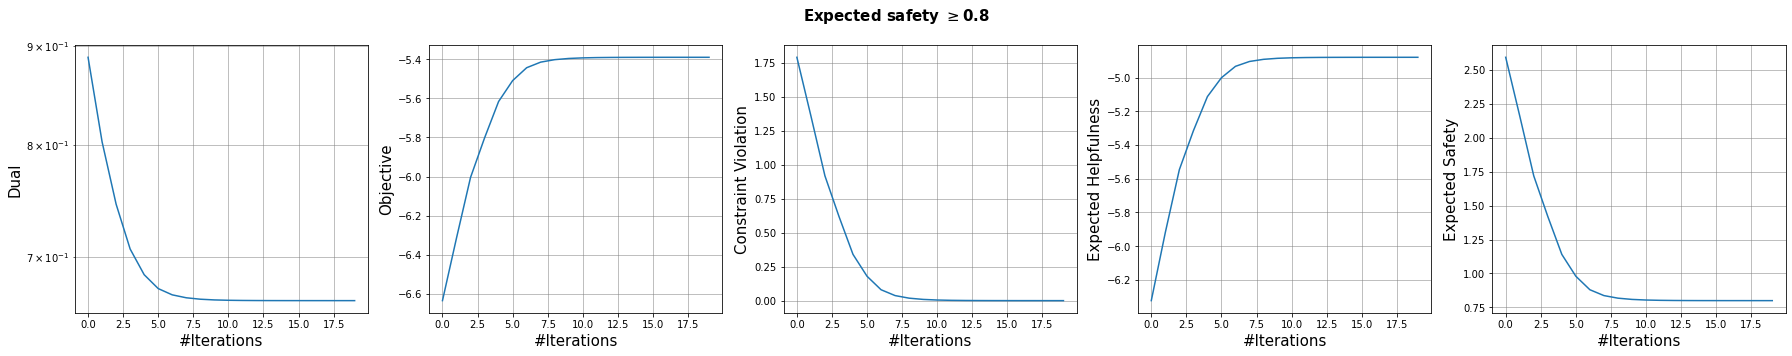

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))  # Adjust the size as needed
axs = axs.flatten()

axs[0].semilogy(lam_trajectory)
axs[0].set_ylabel('Dual', fontsize = 15)

axs[1].plot(objective_trajectory)
axs[1].set_ylabel('Objective', fontsize=15)

axs[2].plot(np.maximum(constraint_trajectory, 0))
axs[2].set_ylabel('Constraint Violation', fontsize=15)

axs[3].plot(helpfulness_trajectory)
axs[3].set_ylabel('Expected Helpfulness', fontsize=15)

axs[4].plot(safety_trajectory)
axs[4].set_ylabel('Expected Safety', fontsize=15)

for i in range(5):
    axs[i].set_xlabel('#Iterations', fontsize=15)
    axs[i].grid(True)
    axs[i].grid(which='both', color='gray', linestyle='-', linewidth=0.5)

fig.suptitle(f'Expected safety $\geq${do.thresholds}', fontsize=15, fontweight='bold')

plt.subplots_adjust(top=0.95)
plt.tight_layout()
plt.show()

## 2. Dual lanscape with respect to the (threshold, #prompts)

In [9]:
threshold_grid = np.linspace(-0.08463882, 2, 20)
num_prompt_grid = list(np.arange(100, 1401, 100))+[full_helpfulness_scores.shape[0]]

lam_tp_list = np.full((len(threshold_grid), len(num_prompt_grid)), None, dtype=object)
for idx_lb, threshold in enumerate(threshold_grid):
    for idx_num, num_prompt in enumerate(num_prompt_grid):
        do = DualOptimizer(full_helpfulness_scores[:num_prompt], full_safety_scores[:num_prompt], thresholds=threshold, kl_coeff=0.1)
        do.solve(lr=2, max_iters=200, set_optimum=True, errr=1-6)
        lam_tp_list[idx_lb][idx_num] = do.lam_star

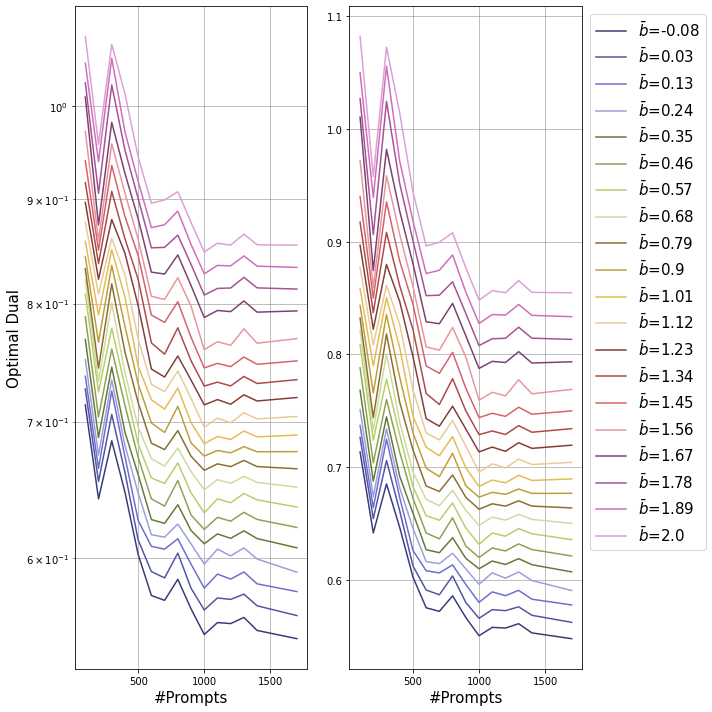

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size as needed
axs = axs.flatten()

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in range(20)]
for idx_lb, threshold in enumerate(threshold_grid):
    if not np.all(lam_tp_list[idx_lb]==None):
        modified_lam_tp_list = [lam for lam in lam_tp_list[idx_lb]]
        for idx_lam, lam in enumerate(modified_lam_tp_list):
            if lam != None:
                modified_lam_tp_list[idx_lam] = np.maximum(lam, 1e-8)
        axs[0].semilogy(num_prompt_grid, modified_lam_tp_list, label=f'$\\bar b$={round(threshold, 2)}', color=colors[idx_lb])
        axs[1].plot(num_prompt_grid, modified_lam_tp_list, label=f'$\\bar b$={round(threshold, 2)}', color=colors[idx_lb])

for i in range(2):
    axs[i].set_xlabel('#Prompts', fontsize=15)
    axs[i].grid(True)
    axs[i].grid(which='both', color='gray', linestyle='-', linewidth=0.5)
axs[0].set_ylabel('Optimal Dual', fontsize=15)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)


plt.subplots_adjust(top=0.95)
plt.tight_layout()
plt.show()


## 3. Dual lanscape with respect to the (threshold, #responses)

In [101]:
threshold_grid = np.array([-3.0258712, -1.5194854,  -0.4047164, 1.21736907, 1.862014770, 2.63174, 2.932037353, 3.785752296447])
num_response_grid = np.arange(48, 193, 8)

lam_tc_list = np.full((len(threshold_grid), len(num_response_grid)), None, dtype=object)
for idx_lb, threshold in enumerate(threshold_grid):
    for idx_num, num_response in enumerate(num_response_grid):
        do = DualOptimizer(full_helpfulness_scores[:,:num_response], full_safety_scores[:,:num_response], thresholds=threshold, kl_coeff=0.1, err=1e-6)
        do.solve(lr=1, max_iters=200, set_optimum=True) # for PGD
        # do.solve(optimizer='scipy', lr=1, max_iters=200, set_optimum=True)
        lam_tc_list[idx_lb][idx_num] = do.lam_star

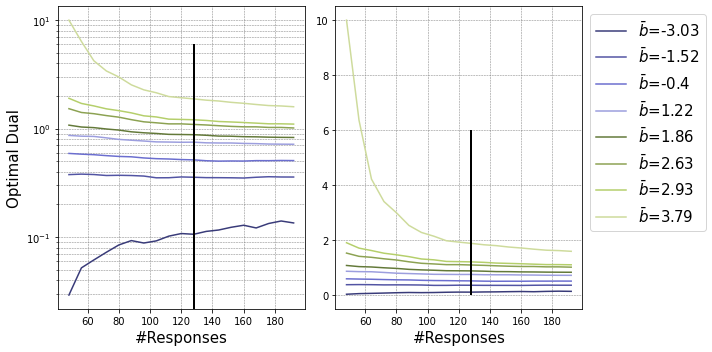

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the size as needed
axs = axs.flatten()

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in range(20)]
for idx_lb, threshold in enumerate(threshold_grid):
    if not np.all(lam_tc_list[idx_lb]==None):
        modified_lam_tc_list = [lam for lam in lam_tc_list[idx_lb]]
        for idx_lam, lam in enumerate(modified_lam_tc_list):
            if lam != None:
                modified_lam_tc_list[idx_lam] = np.maximum(lam, 1e-8)
        axs[0].semilogy(num_response_grid, modified_lam_tc_list, label=f'$\\bar b$={round(threshold, 2)}', color=colors[idx_lb])
        axs[1].plot(num_response_grid, modified_lam_tc_list, label=f'$\\bar b$={round(threshold, 2)}', color=colors[idx_lb])

for i in range(2):
    axs[i].vlines(128, linewidth=2, colors = 'black', ymin=0, ymax=6)
    axs[i].set_xlabel('#Responses', fontsize=15)
    axs[i].grid(True)
    axs[i].grid(which='both', color='gray', linestyle='--', linewidth=0.5)
axs[0].set_ylabel('Optimal Dual', fontsize=15)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)


plt.subplots_adjust(top=0.95)
plt.tight_layout()
plt.show()

## 4. Find the predicted threshold for target $\lambda$

In [118]:
import pdb

class Predictor():
    def __init__(self,
                 helpfulness_scores,
                 safety_scores,
                 **kwargs):
        self.helpfulness_scores = helpfulness_scores
        self.safety_scores = safety_scores
        self.kwargs = kwargs
    
    def predict(self, lam_grid, kl_coeff, threshold_low = -3, threshold_high=3, **kwargs):
        err = 1e-5 if 'err' not in kwargs.keys() else kwargs['err']
        optimizer = 'GD' if 'optimizer' not in kwargs.keys() else kwargs['optimizer']
        def threshold2lam(threshold, err):
            do = DualOptimizer(self.helpfulness_scores, self.safety_scores, thresholds=threshold, kl_coeff=kl_coeff)
            if optimizer != 'scipy':
                am_trajectory, objective_trajectory, constraint_trajectory, helpfulness_trajectory, safety_trajectory = do.solve(optimizer = optimizer, lr=1, max_iters=200, set_optimum=True, err= err)
                return do.lam_star, helpfulness_trajectory[-1]
            else:
                do.solve(optimizer = optimizer, lr=1, max_iters=200, set_optimum=True, err= err)
                return do.lam_star, 0
        lam_low, help_low = threshold2lam(threshold_low, err)
        lam_high, help_high = threshold2lam(threshold_high, err)
        lam2threshold_map = {lam_low: (threshold_low, help_low), lam_high: (threshold_high, help_high)}
        if lam_low == None:
            print(f'The lower threshold bound {threshold_low} is too high!')
            return
        if lam_high == None:
            print(f'The upper threshold bound {threshold_high} is too high!')
            return
        res = {}
        for lam in lam_grid:
            while True:
                lam_list = np.sort(np.array(list(lam2threshold_map.keys())))
                # pdb.set_trace()
                if lam < lam_list[0]-err:
                    print(f'The lower threshold bound is too high to cover lambda={lam}!')
                    break
                elif lam > lam_list[-1] +err:
                    print(f'The upper threshold bound is too low to cover lambda={lam}!')
                    break
                elif lam < lam_list[0]+err:
                    res[lam] = lam2threshold_map[lam_list[0]][0]
                    break
                elif lam > lam_list[-1]-err:
                    res[lam] = lam2threshold_map[lam_list[-1]][0]
                    break
                else:
                    lam_left, lam_right = lam_list[lam_list<lam][-1], lam_list[lam_list>lam][0]
                    if np.abs(lam_left-lam)<err: 
                        res[lam] = lam2threshold_map[lam_left][0]
                        break 
                    elif np.abs(lam_right-lam)<err: 
                        res[lam] = lam2threshold_map[lam_right][0]
                        break
                    else:
                        threshold_mid = (lam2threshold_map[lam_left][0]+lam2threshold_map[lam_right][0])/2
                        lam_tmp, help_tmp = threshold2lam(threshold_mid, err)
                        lam2threshold_map[lam_tmp] = (threshold_mid, help_tmp)

        return res

In [116]:
lam_list = [0.1, 0.3511, 0.5, 0.7547, 0.9, 1.1263, 1.25, 2, 3]
dp = Predictor(full_helpfulness_scores[idx_sample, :128], full_safety_scores[idx_sample, :128])
dp.predict(lam_list, 0.1, threshold_low = -3.5, threshold_high=4.0, errr=1-4, optimizer='scipy')

KeyboardInterrupt: 

In [120]:
lam_list = [0.1, 0.3511, 0.5, 0.7547, 0.9, 1.1263, 1.25, 2, 3]
dp = Predictor(full_helpfulness_scores[idx_sample, :128], full_safety_scores[idx_sample, :128])
dp.predict(lam_list, 0.1, threshold_low = -3.5, threshold_high=4.4, errr=1-6)

{0.1: -3.025898742675781,
 0.3511: -1.5194549560546873,
 0.5: -0.4047805786132811,
 0.7547: 1.2173858642578126,
 0.9: 1.862057495117188,
 1.1263: 2.63176383972168,
 1.25: 2.932040023803711,
 2: 3.785750770568848,
 3: 4.1847566127777105}

## 5. Dual loss landscape

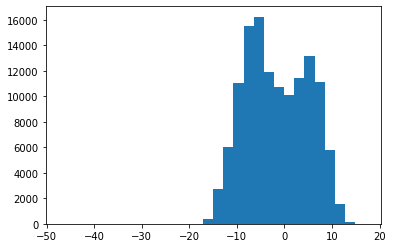

In [42]:
# plt.scatter(full_safety_scores[idx_sample, :128], full_helpfulness_scores[idx_sample, :128], s=0.1)
n, bins, patches = plt.hist(full_safety_scores[idx_sample, :128].reshape(-1), bins=30)
default_color = patches[0].get_facecolor()

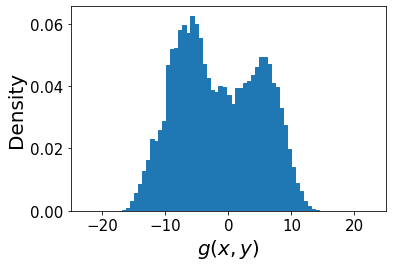

In [73]:

plt.hist(full_safety_scores[idx_sample, :128].reshape(-1), bins=100, edgecolor=default_color, color =default_color, density=True)
plt.xlabel(r'$g(x,y)$', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xlim(-25, 25)
# plt.ylim(-25,10)
plt.subplots_adjust(bottom=0.17, left=0.17)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('dual_safety_boundedness.pdf')

In [7]:
def dual_loss(lam_grid, helpfulness_scores, safety_scores, threshold=1., kl_coeff=0.1):
    res = []
    for lam in lam_grid:
        logits = (helpfulness_scores + (safety_scores - threshold) * lam) / kl_coeff
        logits_max = logits.max(axis=1).reshape(-1, 1)
        res.append(kl_coeff*np.mean(np.log(np.mean(np.exp(logits-logits_max)))+logits_max))
    return np.array(res)

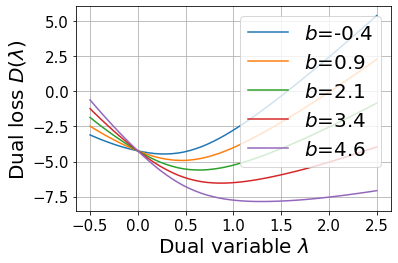

In [75]:
lam_grid = np.linspace(-0.5, 2.5, 50)
threshold_grid = np.linspace(-2, 3, 5)
threshold_SFT = full_safety_scores.mean()
for threshold in threshold_grid:
    losses = dual_loss(lam_grid, full_helpfulness_scores[idx_sample, :128], full_safety_scores[idx_sample, :128], threshold=threshold, kl_coeff=0.1)
    plt.plot(lam_grid, losses, label=rf'$b$={round(threshold-threshold_SFT,1)}')
    # plt.hlines(losses.min()-1e-2,  xmin=-0.5, xmax=2.5, linestyles='dashed', color='black')
plt.xlabel(r'Dual variable $\lambda$', fontsize =20)
plt.ylabel(r'Dual loss $D(\lambda)$', fontsize =20)
plt.subplots_adjust(bottom=0.17, left=0.17)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=20, loc='upper right')
plt.grid()
plt.savefig('dual_loss.pdf')

-2.0 0.27010267873824656
-0.75 0.45670038371066557
0.5 0.647434367643335
1.75 0.870881360929598
3.0 1.2901170881116997


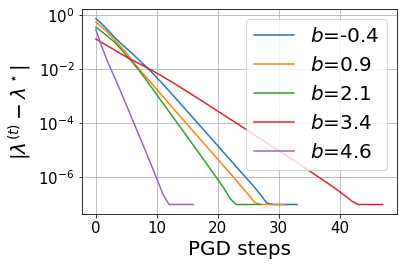

In [76]:
for threshold in threshold_grid:
    do = DualOptimizer(full_helpfulness_scores[idx_sample, :128], full_safety_scores[idx_sample, :128], thresholds=threshold, kl_coeff=0.1)
    # do.solve(optimizer='scipy', set_optimum=True)
    # lam_star = do.lam_star
    lam_trajectory, objective_trajectory, constraint_trajectory, helpfulness_trajectory, safety_trajectory = do.solve(lr=2, max_iters=1000, err=1e-7, set_optimum=True)
    print(threshold, do.lam_star)
    plt.semilogy(np.maximum(np.abs(np.array([1]+lam_trajectory)-do.lam_star), 1e-7), label=rf'$b$={round(threshold-threshold_SFT,1)}')
plt.subplots_adjust(bottom=0.17, left=0.17)
plt.ylabel(r'$|\lambda^{(t)}-\lambda^\star|$', fontsize = 20)
plt.xlabel('PGD steps', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 20)
plt.grid()
plt.savefig('dual_PGD.pdf')